In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("QVI_data.csv")

In [3]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["MONTH"] =  pd.DatetimeIndex(df["DATE"]).month
df["YEAR"] =  pd.DatetimeIndex(df["DATE"]).year
df["DATE_TEST"] = df['DATE'].dt.strftime('%Y%m')

In [5]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH,YEAR,DATE_TEST
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,10,2018,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,9,2018,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,3,2019,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,3,2019,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,11,2018,201811


In [6]:
df.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
MONTH               0
YEAR                0
DATE_TEST           0
dtype: int64

In [8]:
df.dtypes

LYLTY_CARD_NBR               int64
DATE                datetime64[ns]
STORE_NBR                    int64
TXN_ID                       int64
PROD_NBR                     int64
PROD_NAME                   object
PROD_QTY                     int64
TOT_SALES                  float64
PACK_SIZE                    int64
BRAND                       object
LIFESTAGE                   object
PREMIUM_CUSTOMER            object
MONTH                        int64
YEAR                         int64
DATE_TEST                   object
dtype: object

In [4]:
def Full_stores(df):
    #Funcion para definir todas las tiendas que tienen datos completos
    df = df.copy()
    dff = df.groupby(["STORE_NBR"]).agg({"MONTH":"nunique","TOT_SALES":"sum","LYLTY_CARD_NBR" :"nunique","TXN_ID" :"count" })
    dff = dff.loc[dff["MONTH"] == 12]
    dff = dff.reset_index()
    dff = dff.drop(columns=["MONTH"])
    full_stores = dff["STORE_NBR"].to_list()
    return full_stores

In [5]:
def sales_experience(df):
       
    df = df.groupby("STORE_NBR").mean()
    df["AVER_TRANS"] = df["TXN_ID"] / df["LYLTY_CARD_NBR"]
    df = df.drop(columns=["TXN_ID"])
    df.columns = ["Tot_Sales","Numb_Cust","Aver_Trans"]
    return df

In [6]:
def measure(df,x1,x2,x3):
    max_sales = df["Tot_Sales"].max()
    min_sales = df["Tot_Sales"].min()
    max_custom = df["Numb_Cust"].max()
    min_custom = df["Numb_Cust"].min()
    max_trans = df["Aver_Trans"].max()
    min_trans = df["Aver_Trans"].min()
    df["Sales_Measurement"] = 1 - ((df["Tot_Sales"]-max_sales)/(min_sales-max_sales))
    df["Customer_Measurement"] = 1 - ((df["Numb_Cust"]-max_custom)/(min_custom-max_custom))
    df["Trans_Measurement"] = 1 - ((df["Aver_Trans"]-max_trans)/(min_trans-max_trans))
    df["Ranking"] = x1 * (df["Sales_Measurement"])+ x2*(df["Customer_Measurement"])+(df["Trans_Measurement"])* x3
    return df

In [7]:
def search_control_store(df,n_store,x1=1,x2=0.5,x3=0.25):
    
    #Busco tiendas con datos completos
    df = df.copy()
    full_stores = Full_stores(df)
    
    #Tabla con datos importantes 
    data = df.groupby(["STORE_NBR","DATE_TEST"]).agg({"TOT_SALES":"sum","LYLTY_CARD_NBR" :"nunique","TXN_ID" :"count" })
    data = data.reset_index()
    data = data.loc[data["STORE_NBR"].isin(full_stores)]
    
    #Filtro tablas por periodos de interes
    data_normal1 = data.loc[(data["DATE_TEST"] >"201806") & (data["DATE_TEST"] < "201902")]
    data_normal2 = data.loc[data["DATE_TEST"] > "201904"]
    data_normal = pd.concat([data_normal1,data_normal2])
    data_trial = data.loc[(data["DATE_TEST"] > "201901") & (data["DATE_TEST"] < "201905")]
    
    #Tablas con estadisticas importantes
    df_normal = sales_experience(data_normal)
    df_trial = sales_experience(data_trial)
    
    #Ranking 
    ranking_normal = measure(df_normal,x1,x2,x3).reset_index()
    
    
    trial_stores=ranking_normal.loc[ranking_normal["STORE_NBR"] == n_store]
    ranking_normal_2 = ranking_normal.loc[ranking_normal["STORE_NBR"] != n_store]
    result_index = ranking_normal_2['Ranking'].sub(trial_stores.iloc[0]["Ranking"]).abs().idxmin()
    control_store_num = ranking_normal.iloc[result_index].STORE_NBR
    control_store_num = int(control_store_num)   
    control_store = ranking_normal.loc[ranking_normal["STORE_NBR"] == (control_store_num)]
    
    return control_store_num

In [8]:
search_control_store(df=df,n_store=77,x1=1,x2=1,x3=0.25)


90

In [38]:
def graficos(df,n_store,control_store_num):
    # Aca poner el df del periodo a analizar, con los valores en funcion del tiempo
    df=df.copy()
    #Busco tiendas con datos completos
    df = df.copy()
    full_stores = Full_stores(df)
    
    #Tabla con datos importantes 
    data = df.groupby(["STORE_NBR","DATE_TEST"]).agg({"TOT_SALES":"sum","LYLTY_CARD_NBR" :"nunique","TXN_ID" :"count" })
    data = data.reset_index()
    data = data.loc[data["STORE_NBR"].isin(full_stores)]
    
    #Filtro tablas por periodos de interes
    data_normal1 = data.loc[(data["DATE_TEST"] >"201806") & (data["DATE_TEST"] < "201902")]
    data_normal2 = data.loc[data["DATE_TEST"] > "201904"]
    data_normal = pd.concat([data_normal1,data_normal2])
    data_trial = data.loc[(data["DATE_TEST"] > "201901") & (data["DATE_TEST"] < "201905")]
    
    n_store_list = [n_store]
    rest_of_stores = [x for x in full_stores if x not in n_store_list]
    fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,figsize=(16,8))
    fig.subplots_adjust(hspace=0.5)
    ax1.plot(data_normal.loc[data_normal["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).TOT_SALES,color="red",label="Control Store")
    ax1.plot(data_normal.loc[data_normal["STORE_NBR"]==n_store].set_index("DATE_TEST")["TOT_SALES"])
    ax1.plot(data_normal.loc[data_normal["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean()["TOT_SALES"],color="black")
    plt.legend(["Control Store","Trial Stores","Rest of Stores"])
    #ax1.set_ylim(100,1200)
    ax1.set_title("Ventas Mensuales Totales en Periodo Normal")
    
    ax2.plot(data_normal.loc[data_normal["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).LYLTY_CARD_NBR,color="red",label="Control Store")
    ax2.plot(data_normal.loc[data_normal["STORE_NBR"]==n_store].set_index("DATE_TEST")["LYLTY_CARD_NBR"])
    ax2.plot(data_normal.loc[data_normal["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean()["LYLTY_CARD_NBR"],color="black")
    plt.legend(["Control Store","Trial Stores","Rest of Stores"])
    #ax2.set_ylim(20,120)
    ax2.set_title("Clientes Mensuales en Periodo Normal")
    
    ax3.plot((data_normal.loc[data_normal["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).TXN_ID)
         / (data_normal.loc[data_normal["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).LYLTY_CARD_NBR),color="red",label="Control Store")
    ax3.plot((data_normal.loc[data_normal["STORE_NBR"] == n_store].set_index(["DATE_TEST"]).TXN_ID)
         / (data_normal.loc[data_normal["STORE_NBR"] == n_store].set_index(["DATE_TEST"]).LYLTY_CARD_NBR),color="blue")
    ax3.plot((data_normal.loc[data_normal["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean().TXN_ID)
         / (data_normal.loc[data_normal["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean().LYLTY_CARD_NBR),color="black")
    plt.legend(["Control Store","Trial Stores","Rest of Stores"])
    #ax2.set_ylim(20,120)
    ax3.set_title("Transacciones por Cliente en Periodo Normal")

    

In [40]:
def graficos_trial(df,n_store,control_store_num):
    # Aca poner el df del periodo a analizar, con los valores en funcion del tiempo
    df=df.copy()
    #Busco tiendas con datos completos
    df = df.copy()
    full_stores = Full_stores(df)
    
    #Tabla con datos importantes 
    data = df.groupby(["STORE_NBR","DATE_TEST"]).agg({"TOT_SALES":"sum","LYLTY_CARD_NBR" :"nunique","TXN_ID" :"count" })
    data = data.reset_index()
    data = data.loc[data["STORE_NBR"].isin(full_stores)]
    
    #Filtro tablas por periodos de interes
    data_normal1 = data.loc[(data["DATE_TEST"] >"201806") & (data["DATE_TEST"] < "201902")]
    data_normal2 = data.loc[data["DATE_TEST"] > "201904"]
    data_normal = pd.concat([data_normal1,data_normal2])
    data_trial = data.loc[(data["DATE_TEST"] > "201901") & (data["DATE_TEST"] < "201905")]
    
    n_store_list = [n_store]
    rest_of_stores = [x for x in full_stores if x not in n_store_list]
    fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,figsize=(16,8))
    fig.subplots_adjust(hspace=0.5)
    ax1.plot(data_trial.loc[data_trial["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).TOT_SALES,color="red",label="Control Store")
    ax1.plot(data_trial.loc[data_trial["STORE_NBR"]==n_store].set_index("DATE_TEST")["TOT_SALES"])
    ax1.plot(data_trial.loc[data_trial["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean()["TOT_SALES"],color="black")
    plt.legend(["Control Store","Trial Stores","Rest of Stores"])
    #ax1.set_ylim(100,1200)
    ax1.set_title("Ventas Mensuales Totales en Periodo Normal")
    
    ax2.plot(data_trial.loc[data_trial["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).LYLTY_CARD_NBR,color="red",label="Control Store")
    ax2.plot(data_trial.loc[data_trial["STORE_NBR"]==n_store].set_index("DATE_TEST")["LYLTY_CARD_NBR"])
    ax2.plot(data_trial.loc[data_trial["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean()["LYLTY_CARD_NBR"],color="black")
    plt.legend(["Control Store","Trial Stores","Rest of Stores"])
    #ax2.set_ylim(20,120)
    ax2.set_title("Clientes Mensuales en Periodo Normal")
    
    ax3.plot((data_trial.loc[data_trial["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).TXN_ID)
         / (data_trial.loc[data_trial["STORE_NBR"] == control_store_num].set_index(["DATE_TEST"]).LYLTY_CARD_NBR),color="red",label="Control Store")
    ax3.plot((data_trial.loc[data_trial["STORE_NBR"] == n_store].set_index(["DATE_TEST"]).TXN_ID)
         / (data_trial.loc[data_trial["STORE_NBR"] == n_store].set_index(["DATE_TEST"]).LYLTY_CARD_NBR),color="blue")
    ax3.plot((data_trial.loc[data_trial["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean().TXN_ID)
         / (data_trial.loc[data_trial["STORE_NBR"].isin(rest_of_stores)].groupby(["DATE_TEST"]).mean().LYLTY_CARD_NBR),color="black")
    plt.legend(["Control Store","Trial Stores","Rest of Stores"])
    #ax2.set_ylim(20,120)
    ax3.set_title("Transacciones por Cliente en Periodo Normal")


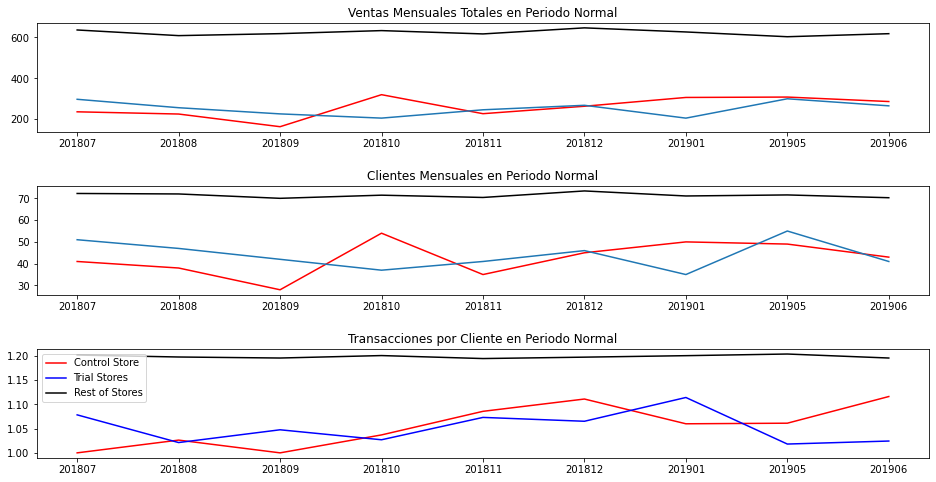

In [42]:
graficos(df,77,90)

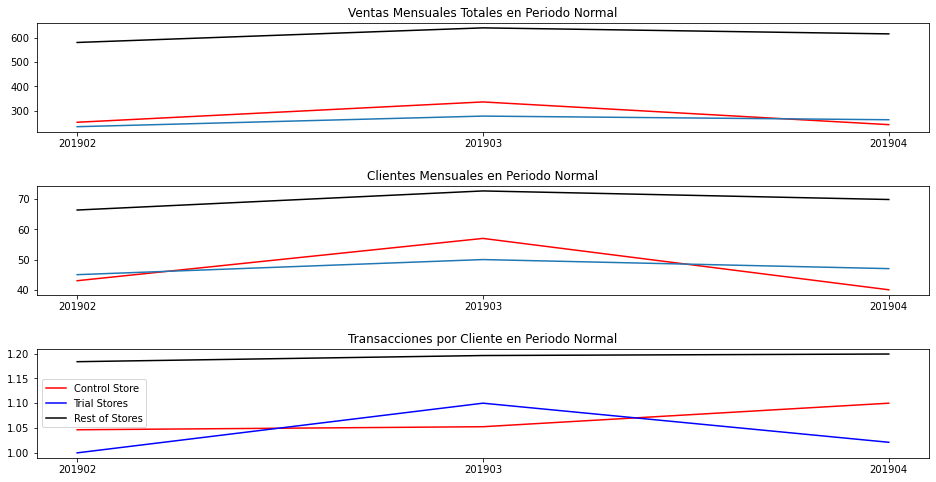

In [43]:
graficos_trial(df,77,90)

In [44]:
search_control_store(df=df,n_store=86,x1=1,x2=1,x3=0.25)

109

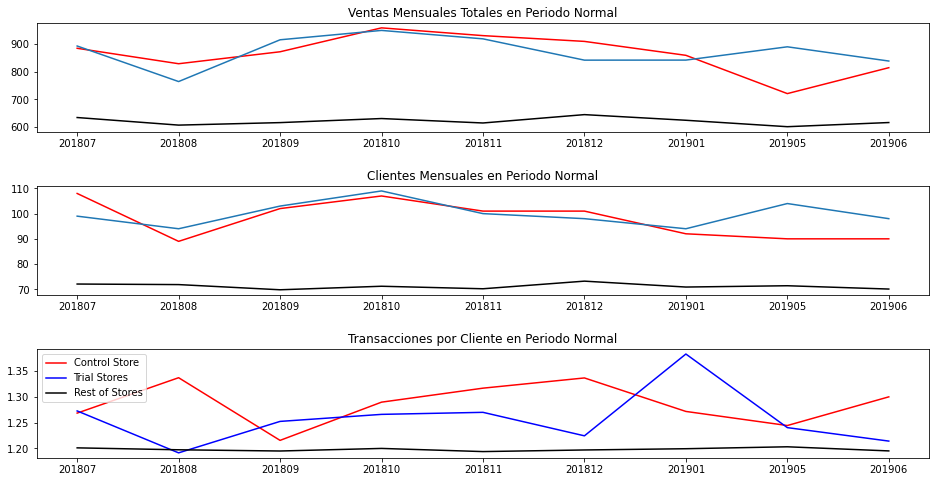

In [45]:
graficos(df,86,109)

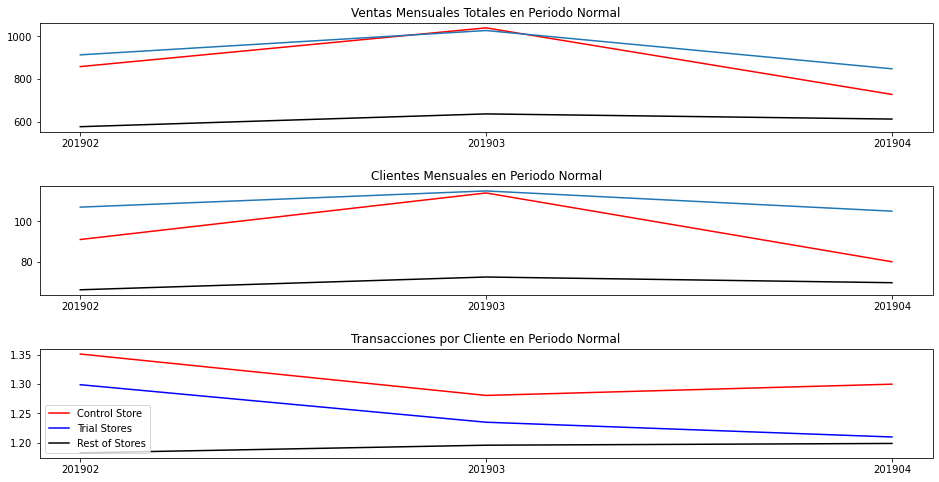

In [46]:
graficos_trial(df,86,109)

In [47]:
search_control_store(df=df,n_store=88,x1=1,x2=1,x3=0.25)

165

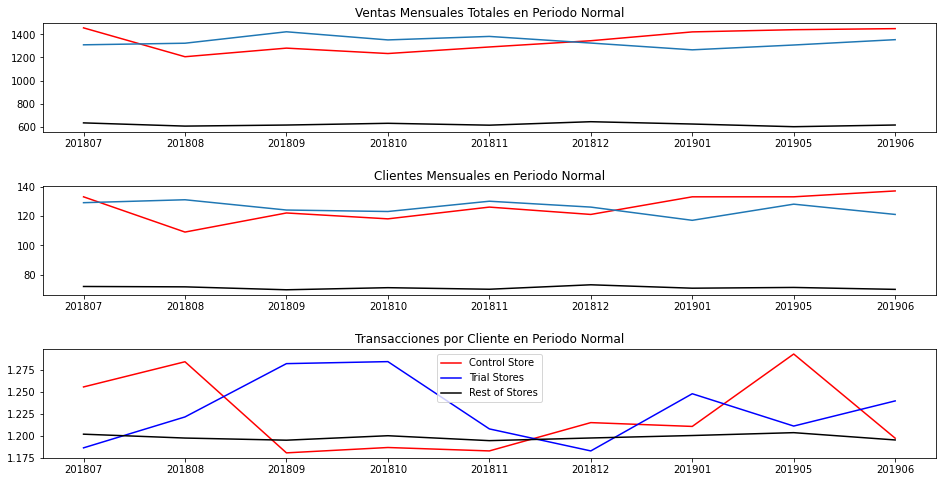

In [48]:
graficos(df,88,165)

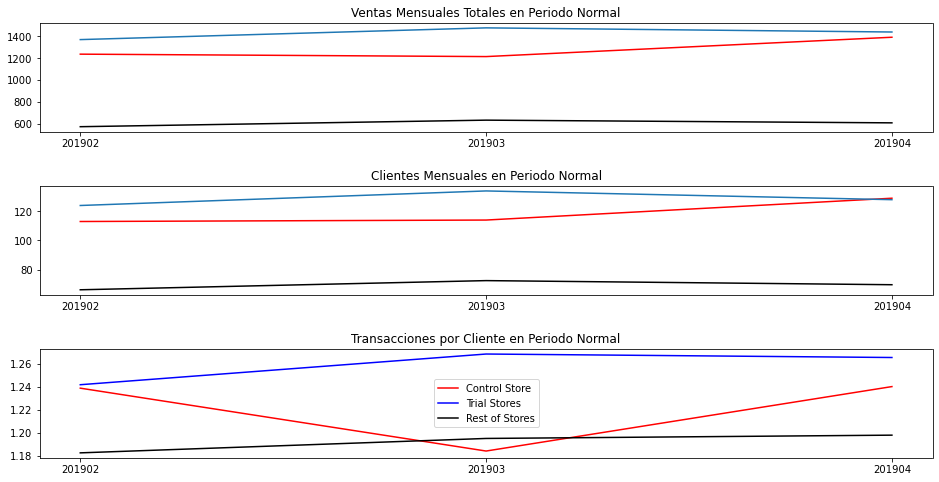

In [49]:
graficos_trial(df,88,165)